# 1. Execution Description

```{note}
執行程式方法：

所有用到的手寫函數放置於 functions.py，其餘針對每題均個別寫一個 python 程式，以 problem1.py, problem2.py, ..., problem6.py 依序命名。
執行時，只要針對執行欲求題目之程式即可。例如想執行回答第一題的程式，就在終端機輸入：
    ```
    python problem1.py
    ```
```

以下區塊是實做細節。

In [1]:
# functions.py 內容
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

def genSample(dataNum, isPrint):
    # Create data points
    X = torch.linspace(-3, 3, steps=dataNum).unsqueeze(0)
    Noise = torch.rand(1, dataNum)
    Y = 2*X + Noise
    data = torch.stack((X,Y), 0)

    # Plot
    if(isPrint == 1):
        plt.scatter(X, Y, color='blue')
        x = np.linspace(-3,3,100)
        plt.plot(x, 2*x, color='black')

        plt.title('Scatter plot of 2D data samples')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    return data

def genSampleSin(dataNum, isPrint):
    # Create data points
    X = torch.linspace(0, 1, steps=dataNum).unsqueeze(0)
    Noise = torch.rand(1, dataNum)*0.04
    Y = torch.sin(2*math.pi*X) + Noise
    data = torch.stack((X,Y), 0)

    # Plot
    if(isPrint == 1):
        plt.scatter(X, Y, color='blue')
        x = np.arange(0, 1, 0.01)
        y = np.sin(2 * np.pi * x)
        plt.plot(x, y, color='black')

        plt.title('Scatter plot of 2D data samples')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    return data

def plot_polynomial(X, Y, coefficients):
    # for y = 2 * x
    plt.scatter(X, Y, color='blue')
    x = torch.linspace(-3,3,1000)
    plt.plot(x, 2*x, color='black')
    coefficients = torch.flip(coefficients, dims = [0])

    y = torch.zeros_like(x)

    for i, c in enumerate(coefficients):
        y += c * torch.pow(x, i)

    plt.plot(x.numpy(), y.numpy())
    plt.xlim(-3, 3)
    plt.ylim(-6, 8)
    plt.show()

def plot_polynomial2(X, Y, coefficients):
    # for y = sin(2 * pi * x)
    plt.scatter(X, Y, color='blue')
    x = np.arange(-10, 10, 0.01)
    y = np.sin(2 * np.pi * x)
    plt.plot(x, y, color='black')

    coefficients = torch.flip(coefficients, dims = [0])
    x = torch.linspace(-3,3,1000)
    y = torch.zeros_like(x)

    for i, c in enumerate(coefficients):
        y += c * torch.pow(x, i)

    plt.plot(x.numpy(), y.numpy())
    #plt.xlim(-2, 2)
    #plt.ylim(-10, 10)
    plt.show()

def LinearRegTrain(X, Y, origX, opt):
    # only find trian error for Linear Regression
    # W = (X.T * X)^(-1) * X.T * Y
    W = (torch.mm(X.T, X)).inverse()
    W = torch.mm(W, X.T)
    W = torch.mm(W, Y)
    
    #  Plot
    if(opt == 1):
        plot_polynomial(origX[:,0], Y , W)
    elif(opt == 2):
        plot_polynomial2(origX[:,0], Y , W)

    # Training Error
    Y_pred = torch.mm(X, W)
    MSE = mean_squared_error(Y, Y_pred)
    
    return MSE

def LinearRegCV(X_train, Y_train, X_test, Y_test):
    # Find validation error for a trained Linear Regression
    # W = (X.T * X)^(-1) * X.T * Y
    W = (torch.mm(X_train.T, X_train)).inverse()
    W = torch.mm(W, X_train.T)
    W = torch.mm(W, Y_train)

    # Test Error
    Y_pred = torch.mm(X_test, W)
    MSE = mean_squared_error(Y_test, Y_pred)
    
    return MSE

def LinearRegRegularCV(X_train, Y_train, X_test, Y_test, n, lambd):
    # Find validation error for a trained Linear Regression
    # W = (X.T * X + lanbda * I)^(-1) * X.T * Y
    W = (torch.mm(X_train.T, X_train))#.inverse()
    W = (W + lambd * torch.eye(n)).inverse()
    W = torch.mm(W, X_train.T)
    W = torch.mm(W, Y_train)

    # Test Error
    Y_pred = torch.mm(X_test, W)
    MSE = mean_squared_error(Y_test, Y_pred)
    
    return MSE

def prob3(X, Y, n, opt):
    # Make X be a n degree tensor
    poly = PolynomialFeatures(n)
    polyX = poly.fit_transform(X)
    polyX = torch.from_numpy(polyX).type(torch.float)

    # Find the training error & plot
    MSE = LinearRegTrain(polyX, Y , X, opt)
    print("Training error: ", MSE)

    # 5-fold cross validation
    kf = KFold(n_splits = 5)
    for (train_index, test_index) in kf.split(polyX):
        X_train, X_test = polyX[train_index], polyX[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        curMSE = LinearRegCV(X_train, Y_train, X_test, Y_test)
        MSE = MSE + curMSE

    MSE = MSE / 5
    print("5-fold cross validation error: ", MSE)

def prob6(X, Y, n, lambd):
    # Make X be a n degree tensor
    poly = PolynomialFeatures(n)
    polyX = poly.fit_transform(X)
    polyX = torch.from_numpy(polyX).type(torch.float)

    # Find the training error & plot
    MSE = LinearRegTrain(polyX, Y , X, 2)

    # 5-fold cross validation
    kf = KFold(n_splits = 5)
    for (train_index, test_index) in kf.split(polyX):
        X_train, X_test = polyX[train_index], polyX[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        
        curMSE = LinearRegRegularCV(X_train, Y_train, X_test, Y_test, n+1, lambd)
        MSE = MSE + curMSE

    MSE = MSE / 5
    print("5-fold cross validation error: ", MSE)

## 1.1 問題一

產生 x 為 -3~3 之間的隨機數字，且equal spacing，而 y 為 x 乘上 2 再加上 0~1 隨機雜訊所得之 data points：

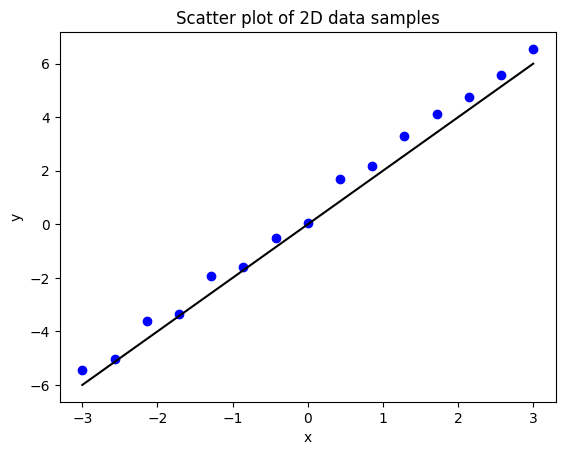

tensor([[[-3.0000, -2.5714, -2.1429, -1.7143, -1.2857, -0.8571, -0.4286,
           0.0000,  0.4286,  0.8571,  1.2857,  1.7143,  2.1429,  2.5714,
           3.0000]],

        [[-5.4514, -5.0439, -3.6109, -3.3463, -1.9304, -1.5825, -0.5083,
           0.0413,  1.6975,  2.1711,  3.3023,  4.1190,  4.7620,  5.5689,
           6.5511]]])

In [2]:
genSample(15, 1)

## 1.2 問題二

###  linear regression (for only training data):

輸入 X, Y 和資料點的數量，就會進行線性回歸，且這個函式最後會回傳 training error。由於之後的題目會需要把原本二維的 X 轉換到高維。

origX 是原本的一維 X 資料，為了能在同個函式裡面一起畫圖，我們最後一個參數傳入原始的 X。而opt 用來選擇畫圖時的基準線，如果是 1，會畫出 $y = 2x$ 的黑色直線，如果是2，會畫出 $y = sin(2πx)$ 的黑色波形。

這個函式用於找 training error。

#### linear regression (for both training & validation data):

輸入訓練和測試資料進行線性回歸，函數最後回傳 testing error。

這個函式用在做 cross validation 時，計算平均 testing error。

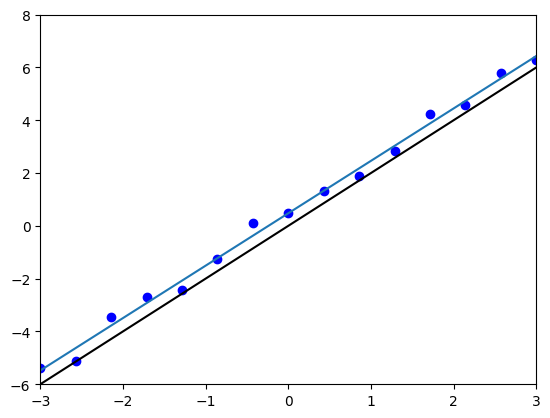

Training error:  0.07514402
5-fold cross validation error:  0.08097800761461257


In [3]:
# Generate dat points
dataSet = genSample(15, 0)
ones = torch.ones(15, 1)
X = dataSet[0].T
X = torch.cat((X, ones), dim = 1)
Y = dataSet[1].T

# Find the training error
MSE = LinearRegTrain(X, Y, X, 1)
print("Training error: ", MSE)

# 5-fold cross validation
kf = KFold(n_splits = 5)
MSE = 0
for (train_index, test_index) in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    curMSE = LinearRegCV(X_train, Y_train, X_test, Y_test)
    MSE = MSE + curMSE

MSE = MSE / 5
print("5-fold cross validation error: ", MSE)

##  1.3 問題三

在這個函式中先產生資料點，並拿三種指定維度的多項式擬合。

我將過程包入函式 prob3(X, Y, n, opt) 中，其中 n 是多項式的維度，opt 用來選擇畫圖時的基準線，如果是 1，會畫出 $y = 2x$ 的黑色直線，如果是2，會畫出 $y = sin(2πx)$ 的黑色波形。

在這裡，進行 linear regression 之前，先利用 sklearn 的 LinearRegTrain，將原本只有一維的 X 資料，轉為指定維度的特徵向量。而後進行步驟與第二題相同。

DEGREE 5:


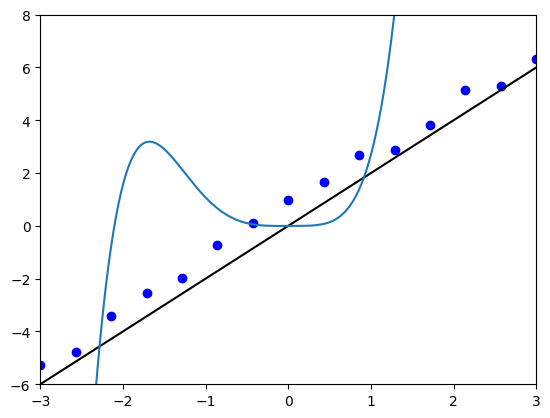

Training error:  0.040098332
5-fold cross validation error:  4.899276351928711
DEGREE 10:


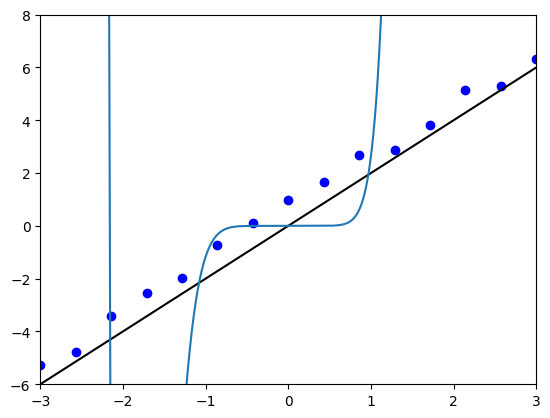

Training error:  0.013101445
5-fold cross validation error:  65014.28125
DEGREE 14:


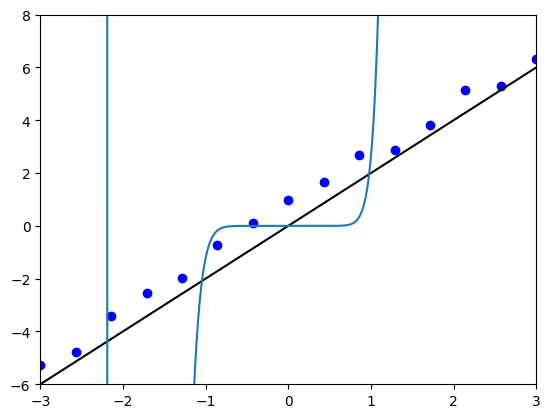

Training error:  1.4707538
5-fold cross validation error:  7787903.2


In [4]:
# Generate dat points
dataSet = genSample(15, 0)
X = dataSet[0].T      
Y = dataSet[1].T

# degree 5 
print('DEGREE 5:')
prob3(X, Y, 5, 1)

# degreer 10 
print('DEGREE 10:')
prob3(X, Y, 10, 1)

# drgree 15
print('DEGREE 14:')
prob3(X, Y, 14, 1)

##  1.4 問題四

在問題四時，新寫一個產生 sin 資料點的函式，而其餘部份使用之函數與 main 架構均與第二與第三題相同。

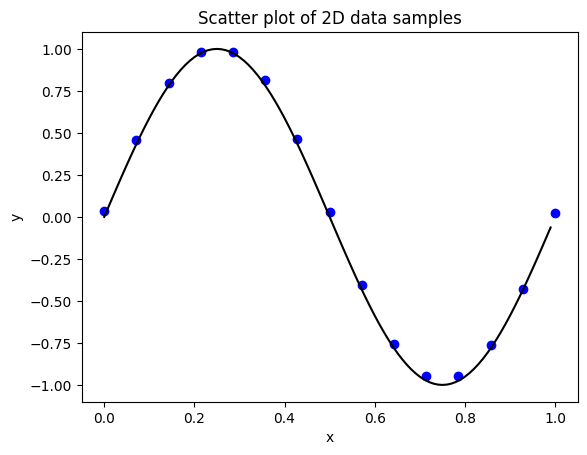

Linear Regression=====================================


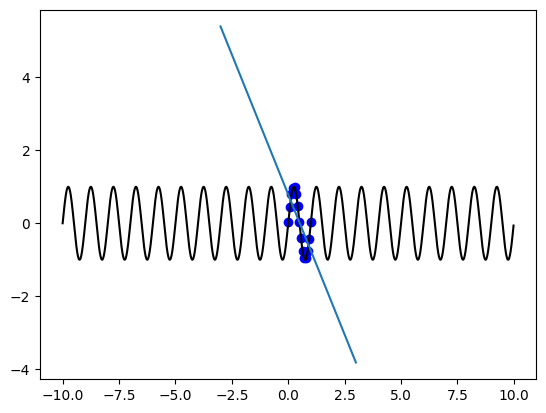

Training error:  0.2388119
5-fold cross validation error:  0.5347871840000152


Polynomial Regression==================================
DEGREE 5:


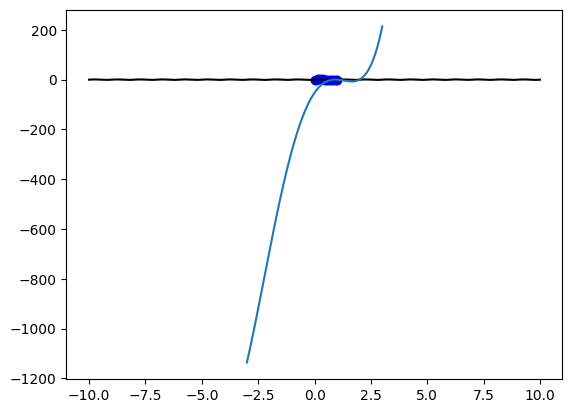

Training error:  0.00010168677
5-fold cross validation error:  0.03205241858959198


DEGREE 10:


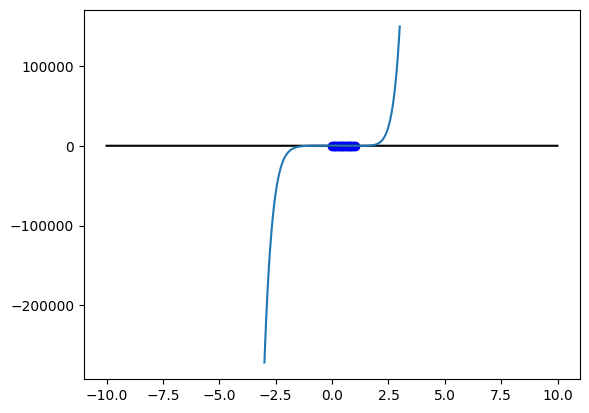

Training error:  4.455726
5-fold cross validation error:  2.5219871520996096


DEGREE 14:


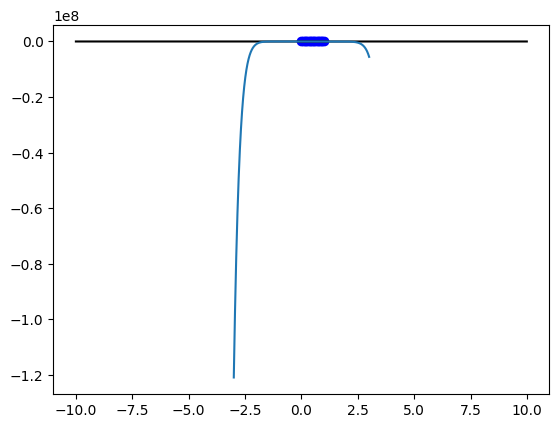

Training error:  6.196093
5-fold cross validation error:  1505.5509765625


In [5]:
# Generate data ================================
dataSet = genSampleSin(15, 1)
X = dataSet[0].T
Y = dataSet[1].T

# Linear Regression =============================
print('Linear Regression=====================================')
ones = torch.ones(15, 1)
X = torch.cat((X, ones), dim = 1)
# Find the training error
MSE = LinearRegTrain(X, Y, X, 2)
print("Training error: ", MSE)

# 5-fold cross validation
kf = KFold(n_splits = 5)
MSE = 0
for (train_index, test_index) in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    curMSE = LinearRegCV(X_train, Y_train, X_test, Y_test)
    MSE = MSE + curMSE

MSE = MSE / 5
print("5-fold cross validation error: ", MSE)
print('\n')

# Polynomial  Regression ==========================
print('Polynomial Regression==================================')
X = dataSet[0].T
# degree 5 
print('DEGREE 5:')
prob3(X, Y, 5, 2)
print('\n')

# degreer 10 
print('DEGREE 10:')
prob3(X, Y, 10, 2)
print('\n')

# drgree 15
print('DEGREE 14:')
prob3(X, Y, 14, 2)

## 1.5 問題五

產生不同資料點數量，並畫出擬合圖形即計算error，main function 架構如下：

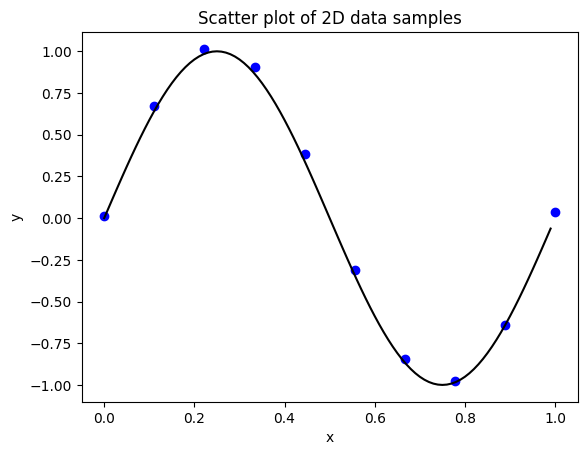

10 DATA POINTS:


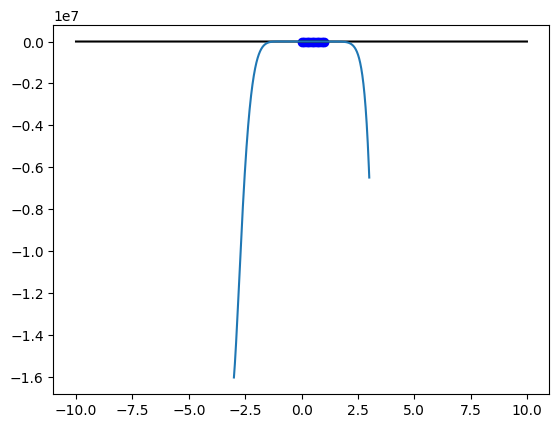

Training error:  10.822795
5-fold cross validation error:  38419.946875




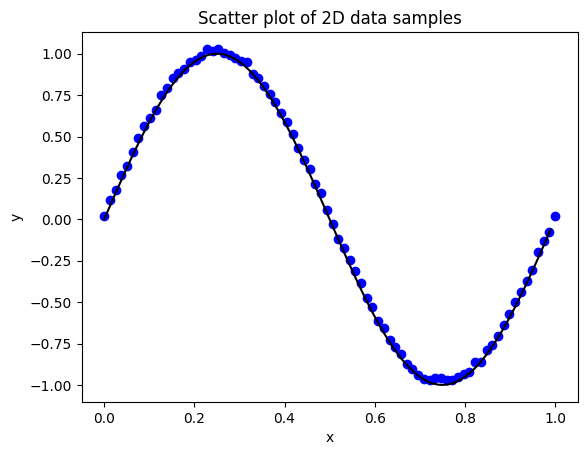

80 DATA POINTS:


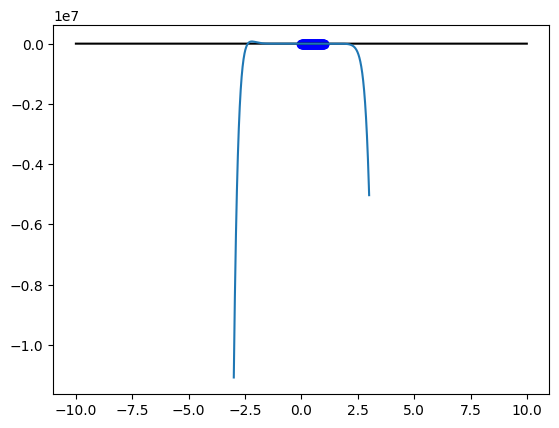

Training error:  3.2361145
5-fold cross validation error:  412.24384765625




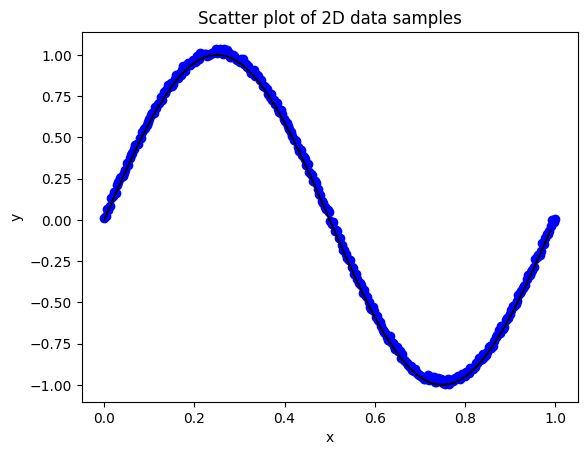

320 DATA POINTS:


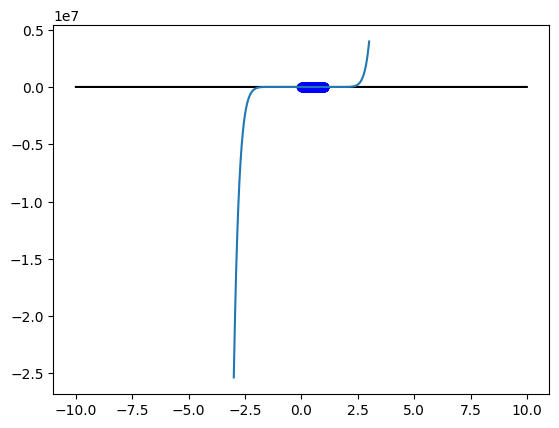

Training error:  0.002529736
5-fold cross validation error:  71.24278564453125


In [6]:
# 10 data points ==========================
dataSet = genSampleSin(10, 1)
X = dataSet[0].T
Y = dataSet[1].T

print('10 DATA POINTS:')
prob3(X, Y, 14, 2)
print('\n')

# 80 data points ==========================
dataSet = genSampleSin(80, 1)
X = dataSet[0].T
Y = dataSet[1].T

print('80 DATA POINTS:')
prob3(X, Y, 14, 2)
print('\n')

# 320 data points =========================
dataSet = genSampleSin(320, 1)
X = dataSet[0].T
Y = dataSet[1].T

print('320 DATA POINTS:')
prob3(X, Y, 14, 2)

## 1.6 問題六

prob6 是類似 prob3 的函式，只是其中使用正規化的函式。

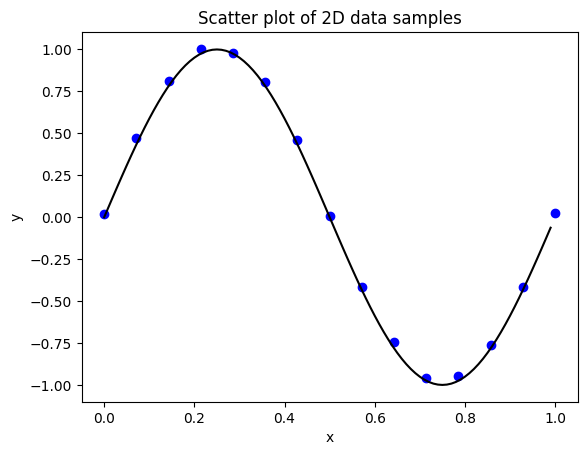

lambda = 0


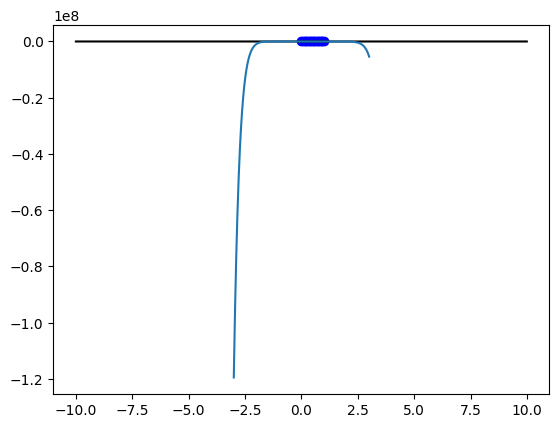

5-fold cross validation error:  2429.4330078125
lambda = 0.001/m


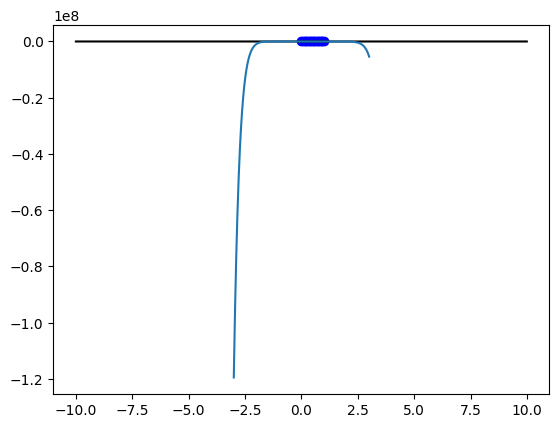

5-fold cross validation error:  1.4292490005493164
lambda = 1/m


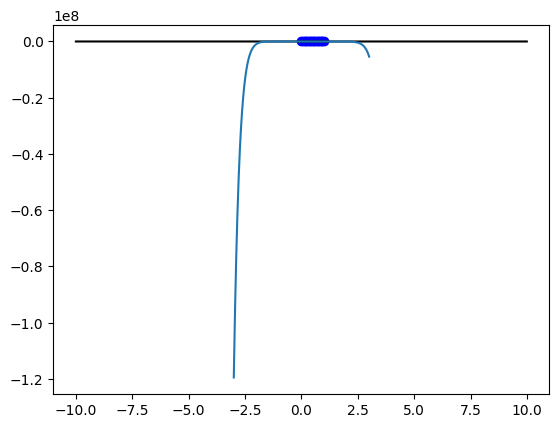

5-fold cross validation error:  2.237751579284668
lambda = 1000/m


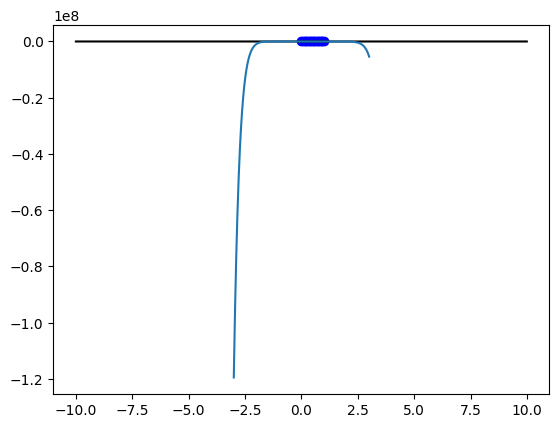

5-fold cross validation error:  1.6809438705444335


In [7]:
# Generate data ================================
# m = 15
dataSet = genSampleSin(15, 1)
X = dataSet[0].T
Y = dataSet[1].T

# regularization ===============================
# lambda = 0
print('lambda = 0')
prob6(X, Y, 14, 0)

# lambda = 0.001/m
print('lambda = 0.001/m')
prob6(X, Y, 14, 0.001/15)

# lambda = 0, 1/m
print('lambda = 1/m')
prob6(X, Y, 14, 1/15)

# lambda = 0, 1000/m
print('lambda = 1000/m')
prob6(X, Y, 14, 1000/15)